
# Multimodel classification 2021 [MI203]
## Classification audio+images

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

datadir = '/kaggle/input/multimodal-classification-2021-mi203/data'

# Data_train
data_df = pd.read_csv(os.path.join(datadir,'data_train.csv'), delimiter=',', nrows = None)
data = np.array(data_df)
labels = data[:,-1].astype('int32')
audio_train = data[:, 1:-1].astype('float32')
img_list = data_df['IMAGE']

# Data_test
data_test_df= pd.read_csv(os.path.join(datadir,'data_test_novt.csv'), delimiter=',', nrows = None)
data_test = np.array(data_test_df)
audio_test = data_test[:, 1:].astype('float32')
img_test_list =data_test_df['IMAGE']

# Classes
class_list = ['FOREST', 'CITY', 'BEACH', 'CLASSROOM', 'RIVER', 'JUNGLE', 'RESTAURANT', 'GROCERY-STORE', 'FOOTBALL-MATCH']

In [2]:
import torch
import random

torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
np.random.seed(42)

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


Using device: cuda



## PARTIE 1 : MODELISATION POUR AUDIO

### Modèle 1 :SVM


#### Diviser aléatoirement les exemples de données en ensemble d'apprentissage et ensemble de test

In [3]:
import matplotlib.pyplot as plt
import random

# Pour séparer les données en apprentissage et test
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Pour normaliser les données
scaler_audio = preprocessing.StandardScaler().fit(audio_train)
audio_train_scaled = scaler_audio.transform(audio_train)
Xn_audio, Xv_audio, yn_audio, yv_audio = train_test_split(audio_train_scaled, labels,
                                                                        random_state=42,
                                                                        test_size=0.1)

#### Entraîner sur l'ensemble d'entraînement et vérifier sur l'ensemble de test pour éviter le surappentissage

In [4]:
from sklearn import svm
def train_svm(Xn, Xv, yn, yv):
    svc = svm.SVC(kernel='rbf', max_iter=-1)
    #svc = svm.SVC(kernel='poly', max_iter=-1,gamma=1, decision_function_shape='ovo')
    ##svc = svm.LinearSVC(max_iter=1000000, tol=1e-6, verbose=True, dual=False)
    svc.fit(Xn, yn)
    score_train = svc.score(Xn, yn)
    score_test = svc.score(Xv, yv)

    print("Taux de reco = {:.2f}% / {:.2f}%".format(score_train*100, score_test*100))
    return svc

svc = train_svm(Xn_audio, Xv_audio, yn_audio, yv_audio)

Taux de reco = 97.15% / 93.41%


#### Générer une matrice de confusion et dessiner des images

In [5]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(yv_audio,svc.predict(Xv_audio))

print(cm)

[[100   0   0   0   0   0   0   0   0]
 [  0 171   5  14   4   0   2   2   1]
 [  0   2 150   1   0   0   2   0   0]
 [  1   0   0 209   1   0   5   0   1]
 [  0   1   1   1 137   0   4   5   0]
 [  0   0   0   0   0 133   0   0   0]
 [  0   1   1   8   3   0  95   4   4]
 [  0   2   0   3   2   0   3 162   0]
 [  0   0   2   0   0   0   0   5 133]]


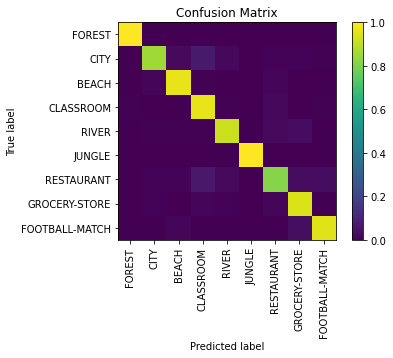

In [6]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels_name, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]   
    plt.imshow(cm, interpolation='nearest')    
    plt.title(title)    
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)   
    plt.yticks(num_local, labels_name)   
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm, class_list, "Confusion Matrix")
# plt.savefig('/HAR_cm.png', format='png')
plt.show()

#### Prediction par modèle svm

In [7]:
y_svm_pred = svc.predict(scaler_audio.transform(audio_test))

### Modèle 2 : MLP

#### Création des datasets et des dataloaders pour audio

In [8]:
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, audio, labels=None):
        self.audio = audio
        self.labels = labels

    def __len__(self):
        return len(self.audio)

    def __getitem__(self, idx):
        audio = self.audio[idx,:]
        if self.labels is not None:
            return audio,int(self.labels[idx])
        else:
            return audio


audio_dataset = AudioDataset(audio=Xn_audio,                                
                                 labels=yn_audio
                              )
audio_test_dataset = AudioDataset(audio=Xv_audio,                               
                                 labels=yv_audio
                              )
## Taille du batch
nsample = 100


audio_test_loader = DataLoader(audio_test_dataset, batch_size=nsample, shuffle=False)
audio_loader = DataLoader(audio_dataset, batch_size=nsample, shuffle=True)

#### Construire le réseau

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

class MonReseau(nn.Module):
    def __init__(self):
        super(MonReseau, self).__init__()
        
        self.linear1 = nn.Linear(104, 208)
        self.linear2 = nn.Linear(208, 208)
        self.linear3 = nn.Linear(208, 419)
        self.final = nn.Linear(419,9)
      
    def forward(self, x):
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.linear2(x))
        x = F.leaky_relu(self.linear3(x))
        x = self.final(x)
        return x

model_audio = MonReseau()
model_audio.to(device)

MonReseau(
  (linear1): Linear(in_features=104, out_features=208, bias=True)
  (linear2): Linear(in_features=208, out_features=208, bias=True)
  (linear3): Linear(in_features=208, out_features=419, bias=True)
  (final): Linear(in_features=419, out_features=9, bias=True)
)

In [10]:
#optimizer = optim.Adam(model_audio.parameters(), lr=0.001)
optimizer = optim.SGD(model_audio.parameters(), lr = 0.05, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.CrossEntropyLoss()

#### Visualisation de scheduler

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


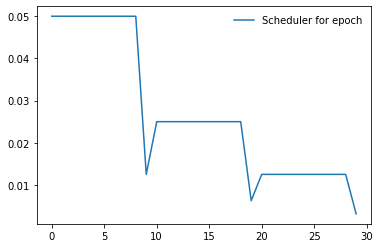

In [11]:
plt.figure()
y = []
for epoch in range(30):
    scheduler.step()
    lr = scheduler.get_lr()
    y.append(scheduler.get_lr()[0])
        
plt.plot( y,label='Scheduler for epoch')
plt.legend(frameon=False)

#### Fonction de entraînement et fonction de validation

In [12]:
from torch.autograd import Variable

def train(model,trainLoader,optimizer,criterion):
    model.train()
    total_loss = 0
    total=0
    for inputs, label in trainLoader:
        inputs = Variable(inputs.cuda()) 
        label = Variable(label.cuda()) 
        optimizer.zero_grad()

        target = model(inputs)
        loss = criterion(target, label)
        loss.backward()
        optimizer.step()
        total += label.size(0)
        total_loss += loss.item()
    return total_loss/float(total)

In [13]:
def evaluate(model,testLoader,criterion):
    model.eval()
    corrects = eval_loss = 0
    total=0
    for inputs, label in testLoader:
        inputs = Variable(inputs.cuda()) 
        label = Variable(label.cuda()) 
        pred = model(inputs)
        loss = criterion(pred, label)
        total+= label.size(0)
        eval_loss += loss.item()
        corrects += (torch.max(pred, 1)[1].view(label.size()).data == label.data).sum()
    return eval_loss/float(total), corrects, corrects*100.0/total, total

In [14]:
import time

def train_epoches(model,trainLoader,testLoader,epochs,scheduler,optimizer,criterion):
    train_loss = []
    valid_loss = []
    accuracy = []

    best_acc = None
    total_start_time = time.time()
    
    print('-' * 90)
    for epoch in range(epochs):
        scheduler.step()
        epoch_start_time = time.time()
        loss = train(model,trainLoader,optimizer,criterion)
        train_loss.append(loss*1000.)

        print('| start of epoch {:3d} | time: {:2.2f}s | train_loss {:5.6f}'.format(epoch,
                                                                              time.time() - epoch_start_time,
                                                                              loss))
        evaluate_start_time = time.time()
        loss, corrects, acc, size = evaluate(model,testLoader,criterion)
        valid_loss.append(loss*1000.)
        accuracy.append(acc)

        print('-' * 10)
        print('| end of epoch {:3d} | time: {:2.2f}s | test_loss {:.4f} | accuracy {}%({}/{})'.format(epoch,
                                                                                                 time.time() - epoch_start_time,
                                                                                                 loss,
                                                                                                 acc,
                                                                                                 corrects,
                                                                                                 size))
        print('-' * 10)
    return train_loss,valid_loss

#### Entraînement du modèle

In [15]:
epochs=30

train_loss = []
valid_loss = []
train_loss,valid_loss=train_epoches(model_audio,audio_loader,audio_test_loader,epochs,scheduler,optimizer,criterion)

------------------------------------------------------------------------------------------
| start of epoch   0 | time: 1.19s | train_loss 0.019273
----------
| end of epoch   0 | time: 1.22s | test_loss 0.0136 | accuracy 62.70818328857422%(866/1381)
----------
| start of epoch   1 | time: 0.41s | train_loss 0.010256
----------
| end of epoch   1 | time: 0.43s | test_loss 0.0081 | accuracy 75.81462860107422%(1047/1381)
----------
| start of epoch   2 | time: 0.41s | train_loss 0.007158
----------
| end of epoch   2 | time: 0.43s | test_loss 0.0063 | accuracy 79.72483825683594%(1101/1381)
----------
| start of epoch   3 | time: 0.40s | train_loss 0.005368
----------
| end of epoch   3 | time: 0.43s | test_loss 0.0048 | accuracy 84.7212142944336%(1170/1381)
----------
| start of epoch   4 | time: 0.40s | train_loss 0.004190
----------
| end of epoch   4 | time: 0.43s | test_loss 0.0041 | accuracy 86.38667297363281%(1193/1381)
----------
| start of epoch   5 | time: 0.41s | train_loss 0.0

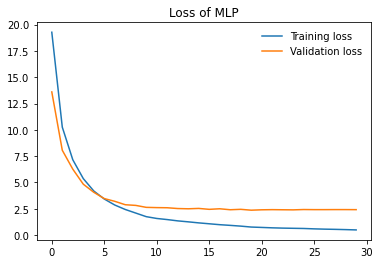

In [16]:
def plot_loss(train_loss, valid_loss, title):
    plt.plot(train_loss, label='Training loss')
    plt.plot(valid_loss, label='Validation loss')
    plt.legend(frameon=False)
    plt.title(title)
    
plot_loss(train_loss, valid_loss, "Loss of MLP")
plt.show()

#### Prediction du modele MLP

In [17]:
import tensorflow as tf
#img_tensor= tf.convert_to_tensor(img_test)
model_audio.eval()
y_mlp_pred = []
audio_test_scaled = scaler_audio.transform(audio_test)
inputs=torch.from_numpy(audio_test_scaled).float()
with torch.no_grad():  ### ici pas besoin de calculer les gradients
    inputs = Variable(inputs.cuda())
    outputs = model_audio(inputs)
    _,pred = outputs.max(1)
    y_mlp_pred.append(pred)

y_mlp_pred=pred.cpu().numpy()
print(y_mlp_pred)

[0 0 0 ... 7 3 1]


## PARTIE2 : MODELISATION POUR IMAGE


### Visualisation d'une image

RESTAURANT


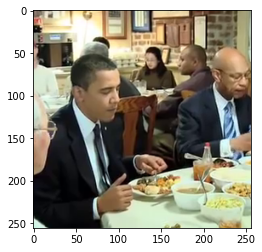

In [18]:

from PIL import Image

# visu image
idx = 5

img = Image.open(os.path.join(datadir, img_list.iloc[idx]))
plt.imshow(np.asarray(img))
print(class_list[labels[idx]])

#### Diviser aléatoirement les données en ensemble d'apprentissage et ensemble de test

In [19]:
from sklearn.model_selection import train_test_split
Xn, Xv, yn, yv = train_test_split(img_list, labels,
                                                    random_state=42,
                                                    test_size=0.1)

#### Créer les datasets et les dataloaders pour image

In [20]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, root_dir, files, labels=None, img_transform=None, audio_transform=None):
        self.root_dir = root_dir
        self.files = files
        self.labels = labels
        self.img_transform = img_transform
        self.audio_transform = audio_transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root_dir, self.files.iloc[idx]))
        if self.img_transform is not None:
            img = self.img_transform(img)
        if self.labels is not None:
            return img, int(self.labels[idx])
        else:
            return img

import torchvision

img_list_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

audio_transform = None

img_dataset = ImageDataset(root_dir=datadir,
                               files=Xn,
                                 labels=yn,
                              img_transform=img_list_transform,
                                 audio_transform=audio_transform)

img_evaluate_dataset = ImageDataset(root_dir=datadir,
                               files=Xv,
                                 labels=yv,
                              img_transform=img_list_transform,
                                 audio_transform=audio_transform)

img_test_dataset = ImageDataset(root_dir=datadir,
                               files=img_test_list,
                                 labels=None,
                              img_transform=img_list_transform,
                                 audio_transform=audio_transform)
## Taille du batch
nsample = 100

# img_dataset = ImageAudioDataset(root_dir=datadir,
#                                files=img_list[:10*nsample],
#                                  audio=audio[:10*nsample,:],
#                                  labels=labels[:10*nsample],
#                               img_transform=img_list_transform,
#                                  audio_transform=audio_transform)

# Shuffle = false pour echantillonner les données dans l'ordre
img_loader = DataLoader(img_dataset, batch_size=nsample, shuffle=False, num_workers=4, pin_memory=True)
img_evaluate_loader = DataLoader(img_evaluate_dataset, batch_size=nsample, shuffle=False, num_workers=4, pin_memory=True)
img_test_loader = DataLoader(img_test_dataset, batch_size=nsample, shuffle=False, num_workers=4, pin_memory=True)

### Modele 1 : resnext50_32x4d

In [21]:
import torchvision.models

resnext = torchvision.models.resnext50_32x4d(pretrained=True)

if device.type == 'cuda':
    resnext = resnext.cuda()

model1 = resnext

for param in model1.parameters():
    param.requires_grad = False

model1.fc = nn.Sequential(nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(512, 9),
                                nn.LogSoftmax(dim=1))
criterion1 = nn.NLLLoss()
optimizer1 = optim.Adam(model1.fc.parameters(), lr=0.002)
scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=10, gamma=0.2)
model1.to(device)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

### Modele 2 : resnet152

In [22]:
resnet = torchvision.models.resnet152(pretrained=True)

if device.type == 'cuda':
    resnet = resnet.cuda()

model2 = resnet

for param in model2.parameters():
    param.requires_grad = False

model2.fc = nn.Sequential(nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(512, 9),
                                nn.LogSoftmax(dim=1))
criterion2 = nn.NLLLoss()
optimizer2 = optim.Adam(model2.fc.parameters(), lr=0.002)
scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=10, gamma=0.2)
model2.to(device)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Modele3 : VGG19

In [23]:
vgg = torchvision.models.vgg19_bn(pretrained=True)

if device.type == 'cuda':
    vgg = vgg.cuda()

model3 = vgg

for param in model3.parameters():
    param.requires_grad = False

model3.classifier._modules['7'] = nn.Sequential(nn.Linear(1000, 512),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(512, 9),
                                nn.LogSoftmax(dim=1))
criterion3 = nn.NLLLoss()
optimizer3 = optim.Adam(model3.classifier.parameters(), lr=0.002)
scheduler3 = optim.lr_scheduler.StepLR(optimizer3, step_size=10, gamma=0.2)
model3.to(device)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

#### entraîner les modèle1, 2 et 3

------------------------------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


| start of epoch   0 | time: 90.86s | train_loss 0.002286
----------
| end of epoch   0 | time: 100.87s | test_loss 0.0006 | accuracy 97.97248077392578%(1353/1381)
----------
| start of epoch   1 | time: 71.73s | train_loss 0.000695
----------
| end of epoch   1 | time: 80.63s | test_loss 0.0006 | accuracy 97.7552490234375%(1350/1381)
----------
| start of epoch   2 | time: 71.51s | train_loss 0.000499
----------
| end of epoch   2 | time: 79.97s | test_loss 0.0004 | accuracy 98.76900482177734%(1364/1381)
----------
| start of epoch   3 | time: 71.30s | train_loss 0.000416
----------
| end of epoch   3 | time: 80.95s | test_loss 0.0004 | accuracy 98.47936248779297%(1360/1381)
----------
| start of epoch   4 | time: 68.93s | train_loss 0.000263
----------
| end of epoch   4 | time: 77.41s | test_loss 0.0003 | accuracy 98.69659423828125%(1363/1381)
----------
| start of epoch   5 | time: 69.13s | train_loss 0.000436
----------
| end of epoch   5 | time: 77.63s | test_loss 0.0004 | accura

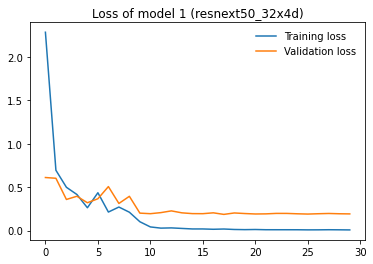

In [24]:
epochs=30

train_loss1 = []
valid_loss1 = []
train_loss1,valid_loss1=train_epoches(model1,img_loader,img_evaluate_loader,epochs,scheduler1,optimizer1,criterion1)
plot_loss(train_loss1, valid_loss1, "Loss of model 1 (resnext50_32x4d)")
plt.show()


------------------------------------------------------------------------------------------
| start of epoch   0 | time: 74.63s | train_loss 0.002413
----------
| end of epoch   0 | time: 83.58s | test_loss 0.0009 | accuracy 96.81390380859375%(1337/1381)
----------
| start of epoch   1 | time: 74.47s | train_loss 0.000616
----------
| end of epoch   1 | time: 83.82s | test_loss 0.0009 | accuracy 96.81390380859375%(1337/1381)
----------
| start of epoch   2 | time: 75.19s | train_loss 0.000492
----------
| end of epoch   2 | time: 84.51s | test_loss 0.0004 | accuracy 98.55177307128906%(1361/1381)
----------
| start of epoch   3 | time: 73.31s | train_loss 0.000371
----------
| end of epoch   3 | time: 82.60s | test_loss 0.0003 | accuracy 98.98624420166016%(1367/1381)
----------
| start of epoch   4 | time: 74.11s | train_loss 0.000392
----------
| end of epoch   4 | time: 83.43s | test_loss 0.0005 | accuracy 98.47936248779297%(1360/1381)
----------
| start of epoch   5 | time: 73.14s | t

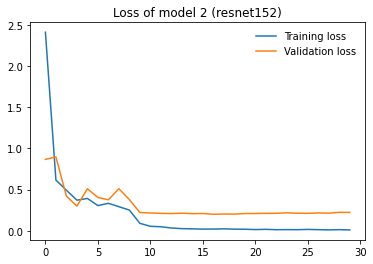

In [25]:
train_loss2 = []
valid_loss2 = []
train_loss2,valid_loss2=train_epoches(model2,img_loader,img_evaluate_loader,epochs,scheduler2,optimizer2,criterion2)
plot_loss(train_loss2, valid_loss2, "Loss of model 2 (resnet152)")
plt.show()


------------------------------------------------------------------------------------------
| start of epoch   0 | time: 72.10s | train_loss 0.002767
----------
| end of epoch   0 | time: 81.19s | test_loss 0.0009 | accuracy 97.10354614257812%(1341/1381)
----------
| start of epoch   1 | time: 72.00s | train_loss 0.001433
----------
| end of epoch   1 | time: 81.10s | test_loss 0.0008 | accuracy 97.97248077392578%(1353/1381)
----------
| start of epoch   2 | time: 71.63s | train_loss 0.001221
----------
| end of epoch   2 | time: 80.56s | test_loss 0.0011 | accuracy 96.95872497558594%(1339/1381)
----------
| start of epoch   3 | time: 71.21s | train_loss 0.001344
----------
| end of epoch   3 | time: 80.99s | test_loss 0.0007 | accuracy 97.8276596069336%(1351/1381)
----------
| start of epoch   4 | time: 71.61s | train_loss 0.001188
----------
| end of epoch   4 | time: 80.53s | test_loss 0.0007 | accuracy 98.33454132080078%(1358/1381)
----------
| start of epoch   5 | time: 71.90s | tr

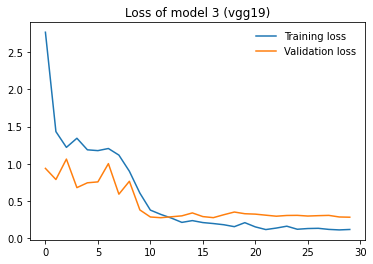

In [26]:
train_loss3 = []
valid_loss3 = []
train_loss3,valid_loss3=train_epoches(model3,img_loader,img_evaluate_loader,epochs,scheduler3,optimizer3,criterion3)
plot_loss(train_loss3, valid_loss3, "Loss of model 3 (vgg19)")
plt.show()

### Prediction du modele1, 2 et 3

In [27]:
import tensorflow as tf
#img_tensor= tf.convert_to_tensor(img_test)
model1.eval()
model2.eval()
model3.eval()

y_cnn_pred1 = []
y_cnn_pred2 = []
y_cnn_pred3 = []
for inputs in img_test_loader:
    with torch.no_grad():  ### ici pas besoin de calculer les gradients
        inputs = inputs.to(device)
        outputs1 = model1.forward(inputs)
        _,pred = outputs1.max(1)
        y_cnn_pred1 = np.hstack((y_cnn_pred1,pred.cpu().numpy()))
        
        outputs2 = model2.forward(inputs)
        _,pred = outputs2.max(1)
        y_cnn_pred2 = np.hstack((y_cnn_pred2,pred.cpu().numpy()))
        
        outputs3 = model3.forward(inputs)
        _,pred = outputs3.max(1)
        y_cnn_pred3 = np.hstack((y_cnn_pred3,pred.cpu().numpy()))
        
y_cnn_pred1=y_cnn_pred1.astype(np.int16)
y_cnn_pred2=y_cnn_pred2.astype(np.int16)
y_cnn_pred3=y_cnn_pred3.astype(np.int16)

## PARTIE 3 : VOTING

Selon les résultats soumis séparément, on a: 
Modele(resnext50_32x4d) = Modele(resnet152) > Modele(MLP) > Modele(SVM) > Modele(VGG19)

In [28]:
y_pred_total = np.vstack((y_cnn_pred1,y_cnn_pred2,y_mlp_pred,y_svm_pred,y_cnn_pred3)).T.astype(np.int16)
y_pred = np.zeros(img_test_list.shape[0])
for i in range(img_test_list.shape[0]):
    y_pred[i] = np.argmax(np.bincount(y_pred_total[i]))
y_pred = y_pred.astype(np.int16)

## PARTIE 4 : CRÉATION ET SAUVEGARDE DU FICHER DE SOUMISSION

In [29]:
#====================================================================
# Création du ficher de soumission

submission = pd.DataFrame({'CLASS':y_pred})
submission=submission.reset_index()
submission = submission.rename(columns={'index': 'Id'})

#======================================================================
# Sauvegarde du fichier
submission.to_csv('submission.csv', index=False)